### Taken from https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

### Dataset downloaded from https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist?resource=download-directory

### Downloaded zip file: Extract. Then files from 01,02,03,04,05 folders are used.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
import keras
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import EarlyStopping
# Set paths to input and output data
INPUT_DIR = 'Audio_MNIST_data'
OUTPUT_DIR = 'Audio_MNIST_data_formatted'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(5):
    print(parent_list[i])

2023-08-08 13:00:13.710349: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 13:00:13.895740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 13:00:13.897296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 13:00:14.925563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


4_05_28.wav
4_01_32.wav
4_01_40.wav
4_04_35.wav
7_05_49.wav


## Plotting some audio files

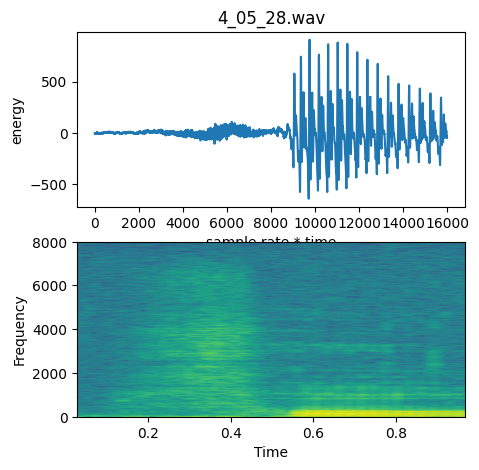

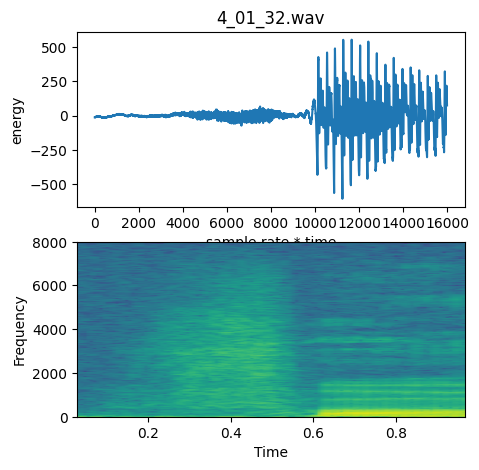

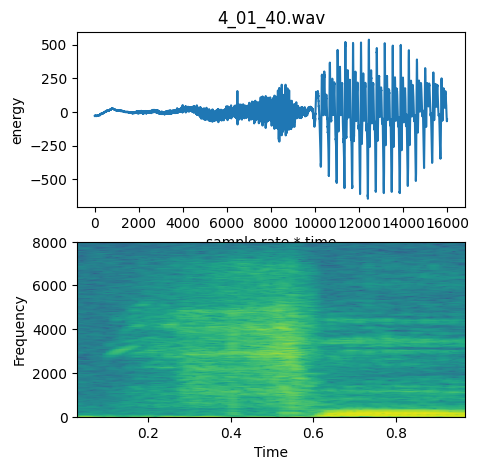

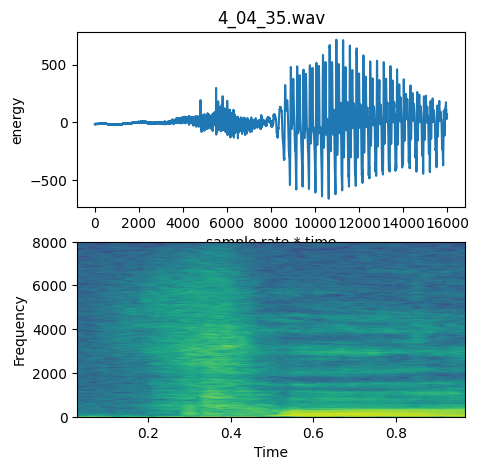

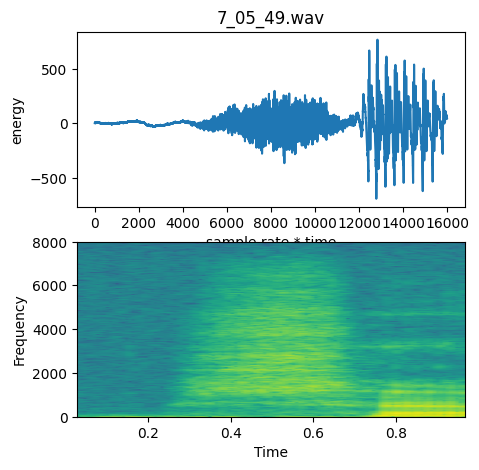

In [2]:
for i in range(5): 
    signal_wave = wave.open(INPUT_DIR+'/'+parent_list[i], 'r')
    sample_rate = 16000
    sig = np.frombuffer(signal_wave.readframes(sample_rate), dtype=np.int16)

    plt.figure(figsize=(5,5))
    plot_a = plt.subplot(211)
    plot_a.set_title(parent_list[i])
    plot_a.plot(sig)
    plot_a.set_xlabel('sample rate * time')
    plot_a.set_ylabel('energy')

    plot_b = plt.subplot(212)
    plot_b.specgram(sig, NFFT=1024, Fs=sample_rate, noverlap=900)
    plot_b.set_xlabel('Time')
    plot_b.set_ylabel('Frequency')

plt.show()

## Utility function to get sound and frame rate info. (Don't run again)

In [3]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_1
class_0
class_4
class_7
class_3
class_2
class_6
class_5
class_9
class_8

A few example files: 

1_02_44.png
1_02_42.png
1_01_35.png
1_03_20.png
1_02_47.png
1_01_1.png
1_01_27.png
1_01_21.png
1_04_15.png
1_03_44.png


## Preparing datasets for training and validation (Next time, start from here. Skip previous cell run)

In [2]:
# Declare constants
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 2499 files belonging to 10 classes.
Using 2000 files for training.
Found 2499 files belonging to 10 classes.
Using 499 files for validation.


## Function to prepare our datasets for modelling.

In [3]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

## 1. Build a classifier and training.

###### Training for only few epochs.

In [4]:
# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.batches = []
        self.weight_save = []
        self.model_weights = model.get_weights()
        self.weight_masks = []
        for i in range(len(self.model_weights)):
            if i%2 == 0:
                self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.weight_masks.append(self.random_mask)
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights)       

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.batches.append(batch)
        self.model_weights = model.get_weights()
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[int(i/2)])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights) 
       
                
l_history=LossHistory()

# Train model for 10 epochs, capture the history
history = model.fit(train_dataset, epochs=3, validation_data=valid_dataset, verbose = 1, callbacks = [es, l_history])

Epoch 1/3


2023-08-08 13:00:57.091777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_4}}]]
2023-08-08 13:00:57.092429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2000]
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 2.3029 - accuracy: 0.0965

2023-08-08 13:01:25.405025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [499]
	 [[{{node Placeholder/_4}}]]
2023-08-08 13:01:25.405382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [499]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - 31s 459ms/step - loss: 2.3029 - accuracy: 0.0965 - val_loss: 2.3031 - val_accuracy: 0.0982
Epoch 2/3
63/63 [==============================] - 28s 439ms/step - loss: 2.3027 - accuracy: 0.0955 - val_loss: 2.3036 - val_accuracy: 0.0802
Epoch 3/3
63/63 [==============================] - 28s 433ms/step - loss: 2.3027 - accuracy: 0.0965 - val_loss: 2.3038 - val_accuracy: 0.0802


#### Ploting the model performance.

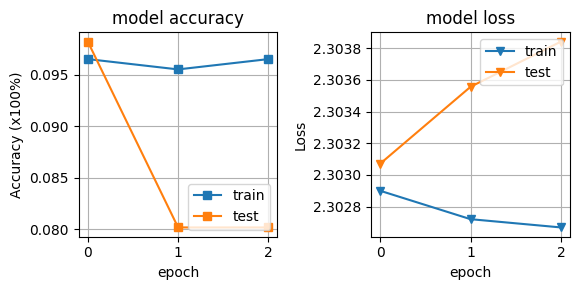

In [5]:
# plotting the metrics
fig = plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], marker = 's')
plt.plot(history.history['val_accuracy'], marker = 's')
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], marker = 'v')
plt.plot(history.history['val_loss'], marker = 'v')
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


#### Evaluating model performance

In [6]:
loss_and_metrics = model.evaluate(valid_dataset, verbose=2)

print("Test Loss {}.".format(loss_and_metrics[0]))
print("Test Accuracy {}%".format(loss_and_metrics[1]*100))

16/16 - 2s - loss: 2.3038 - accuracy: 0.0802 - 2s/epoch - 137ms/step
Test Loss 2.303840398788452.
Test Accuracy 8.016031980514526%


### Check Sparsity

% of zeros = 0.9745370370370371


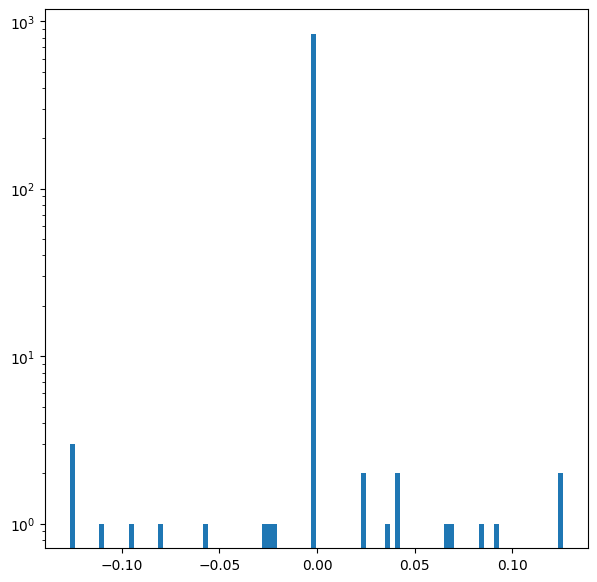

In [7]:
w = model.layers[0].weights[0].numpy()
h, b = np.histogram(w, bins=100)
plt.figure(figsize=(7, 7))
plt.bar(b[:-1], h, width=b[1] - b[0])
plt.semilogy()
print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

In [10]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = strip_pruning(model)

In [17]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['dense_1_softmax']['Strategy'] = 'Stable'
print(hls_config)

cfg = hls4ml.converters.create_config(backend='Vivado')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'model_Sparse_AudioMNIST/'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 128, 128, 32]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 128, 128, 32]], output shape: [None, 128, 128, 32]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 128, 128, 32]], output shape: [None, 64, 64, 32]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 64, 64, 32]], output shape: [None, 64, 64, 32]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 64, 64, 32]], output shape: [None, 64, 64, 64]
Layer name: batch_normalization_2, layer type: BatchNormalization, input shapes: [[None, 64, 64, 64]], output shape: [None, 64, 64, 64]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 64, 64, 64]], ou

In [19]:
hls_model.build(csim=False, synth=True, vsynth=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /home/rrk307/Xilinx/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/rrk307/Xilinx/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rrk307' on host 'ADUAED10599LPLX' (Linux_x86_64 version 5.4.0-150-generic) on Tue Aug 08 13:38:10 +04 2023
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/rrk307/model_Sparse_AudioMNIST'
INFO: [HLS 200-10] Opening project '/home/rrk307/model_Sparse_AudioMNIST/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'firmware/weights' to the pr

{}

#### HLS4Ml compiler error. Working on this to get it run. Some workaround:
#### 1. Use different version of HLS4ML
#### 2. Use different version of Vivado
#### 3. Use large server with large memory to execute the synthesis.
